# General Approach 

The general approach of this notebook is :

1. Implementing `Word2Vec` as Vectorization method.

2. `PCA` and `T-SNE` as Dimension re duction methods.

3. `Kmeans`, `Hierarchical Clustering`, `AgglomerativeClustering` as Clustering methods.

4. `Elbow` for estimating number of clusters as `K`.

5. `LDA` as Latent Dirichlet Allocation for `Topic` generator.
AgglomerativeClustering
6. `Classification` base on Kmeans: `SGDClassifier`.

### Libraries

- `gensim`: A library for unsupervised topic modelling and natural language processing. It provides implementations of algorithms such as Word2Vec, Doc2Vec, FastText, and others, which can be used to generate vector representations of words, sentences, or documents [Source 0](https://radimrehurek.com/gensim/).

- `PCA`: Principal Component Analysis is a technique used to emphasize variation and bring out strong patterns in a dataset. It's often used to make data easy to explore and visualize [Source 1](https://en.wikipedia.org/wiki/Principal_component_analysis).

- `KMeans`: A type of unsupervised machine learning algorithm used to classify items into groups (clusters). It's often used in market segmentation, document clustering, image segmentation, and anomaly detection [Source 2](https://en.wikipedia.org/wiki/K-means_clustering).

- `metrics`: This is a module in scikit-learn that provides functions to calculate performance metrics for regression or classification problems. It includes measures such as accuracy, precision, recall, F1 score, mean squared error, mean absolute error, etc [Source 3](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

- `scipy.spatial.distance`: This module provides functions for calculating distances between vectors. It's often used in clustering, nearest neighbor searches, and other applications that involve comparing the similarity of objects [Source 4](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html).

- `matplotlib`: A plotting library for creating static, interactive, and animated visualizations in Python. It provides a flexible and powerful system for drawing and representing data in Python [Source 5](https://matplotlib.org/stable/users/index.html).

- `seaborn`: A statistical plotting library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics [Source 6](https://seaborn.pydata.org/introduction.html).

- `LatentDirichletAllocation`: A class in scikit-learn that implements Latent Dirichlet Allocation (LDA), a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. It's often used for topic modeling [Source 7](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html).

- `CountVectorizer`: A class in scikit-learn that converts a collection of text documents to a matrix of token counts. It's often used for text preprocessing in Natural Language Processing (NLP) tasks [Source 8](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).


In [2]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer



In [4]:
# Load the dataset
path = '/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/proceed_data/cleaned_dataset.csv'
cleaned_df = pd.read_csv(path)

cleaned_df['tokenized_text'] = cleaned_df.apply(lambda row: row['title'].split() + row['abstract'].split(), axis=1)

# Train the Word2Vec model
# For simplicity, the Word2Vec model is trained on the dataset itself, but for better quality embeddings, a pre-trained model can be used
w2v_model = Word2Vec(sentences=cleaned_df['tokenized_text'], vector_size=100, window=5, min_count=1, workers=4)

# Transform each document into a vector by averaging its word vectors
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in w2v_model.wv.index_to_key]
    return np.mean(w2v_model.wv[doc], axis=0) if len(doc) > 0 else np.zeros(w2v_model.vector_size)

cleaned_df['doc_vector'] = cleaned_df['tokenized_text'].apply(document_vector)

# Convert the results into a format suitable for clustering
doc_vectors = np.vstack(cleaned_df['doc_vector'])

# Optionally, use PCA to reduce dimensionality
pca = PCA(n_components=50)
doc_vectors_reduced_pca = pca.fit_transform(doc_vectors)
print(doc_vectors_reduced_pca.shape)
print(doc_vectors_reduced_pca)

# Now you can use KMeans or any other clustering technique on 'doc_vectors_reduced'
# ... Rest of the clustering code

(22787, 50)
[[ 2.8528066   0.11808371  0.3543409  ... -0.04748435 -0.23130816
   0.0598661 ]
 [ 2.909078    0.14796981 -0.62595904 ...  0.20482148  0.1246158
  -0.06471673]
 [ 2.547473   -0.5785542  -0.33392668 ...  0.04994347  0.24569386
   0.30952215]
 ...
 [ 3.740345    0.8814998   0.05281175 ... -0.00660772 -0.07130148
   0.0550767 ]
 [ 3.2590647   0.32629636  0.8674519  ...  0.11291903  0.3696576
   0.2943498 ]
 [ 1.2655057  -0.50572705  1.2299672  ... -0.28101864 -0.01302428
   0.12202091]]


/tmp/ipykernel_18398/822242376.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=doc_vectors_reduced_pca[:,0], y=doc_vectors_reduced_pca[:,1], palette=palette)  # Specify x and y explicitly


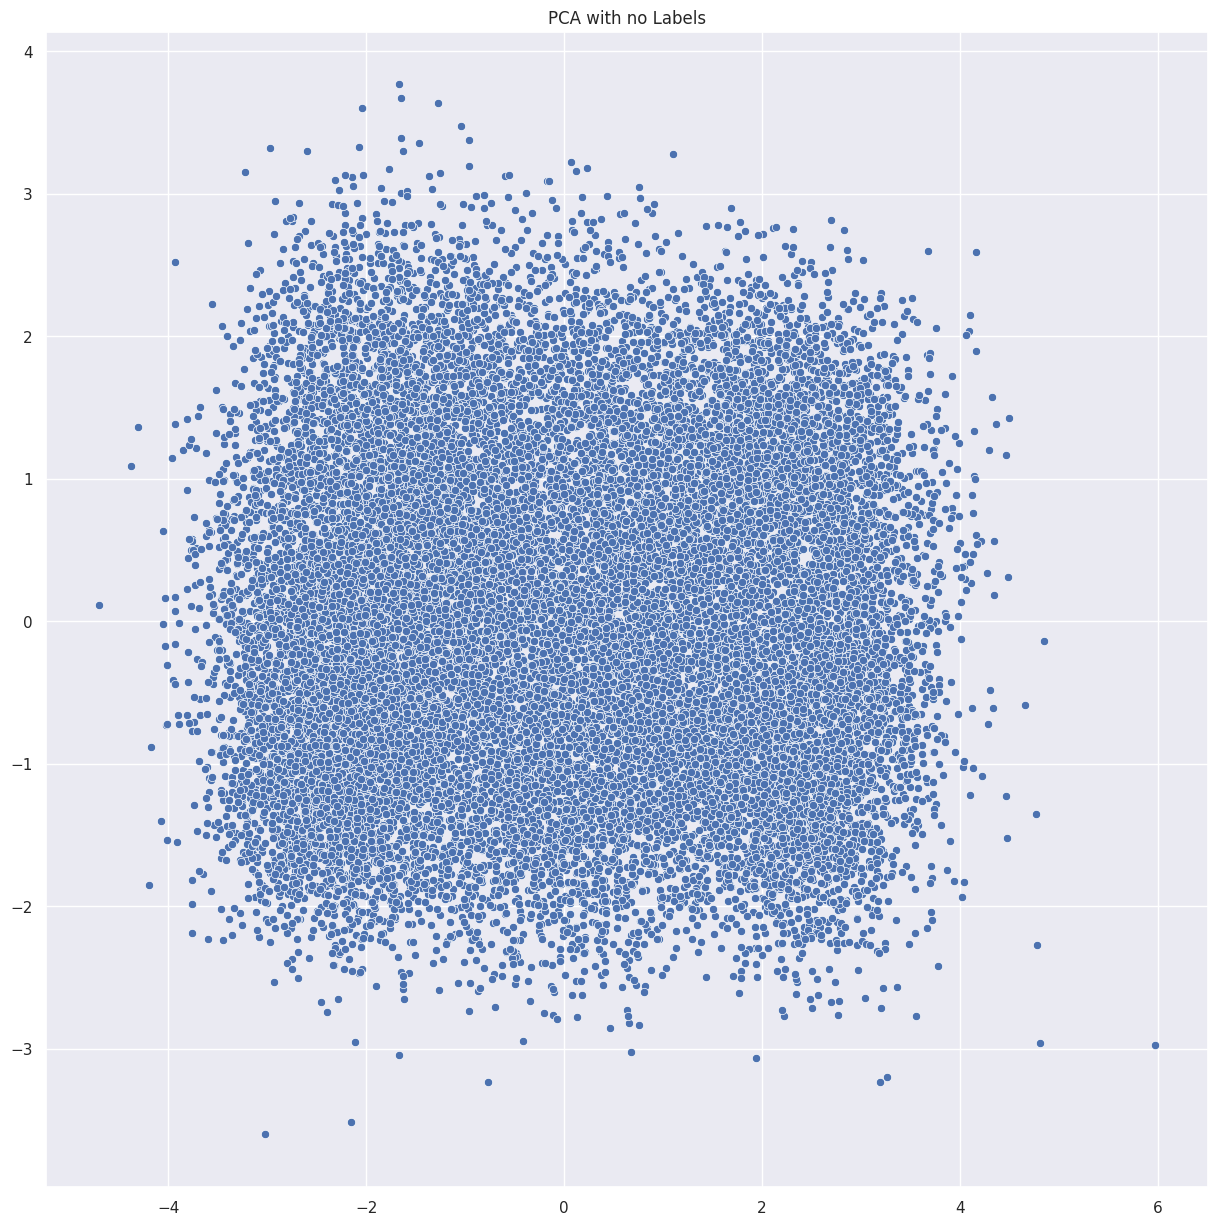

In [5]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=doc_vectors_reduced_pca[:,0], y=doc_vectors_reduced_pca[:,1], palette=palette)  # Specify x and y explicitly
plt.title('PCA with no Labels')
plt.savefig("/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/results/word2vec_PCA_covid19.png")
plt.show()

### How many clusters? 

To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

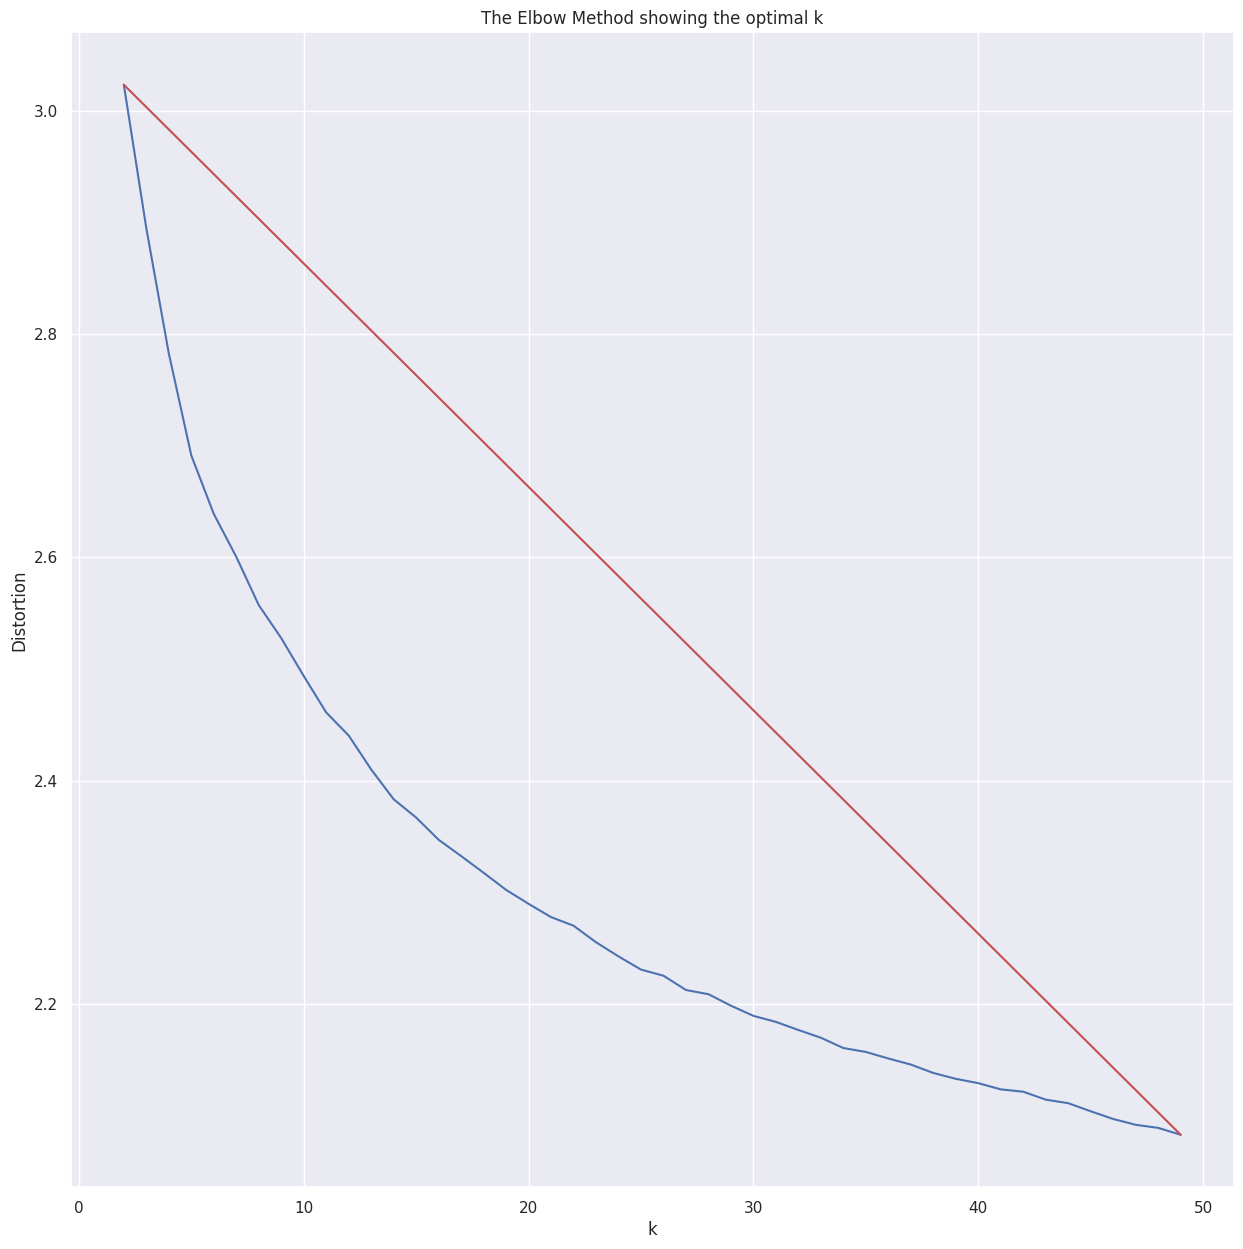

In [6]:

distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k).fit(doc_vectors_reduced_pca)
    k_means.fit(doc_vectors_reduced_pca)
    distortions.append(sum(np.min(cdist(doc_vectors_reduced_pca, k_means.cluster_centers_, 'euclidean'), axis=1)) / doc_vectors.shape[0])

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Run k-means

Now that we have an appropriate k value, we can run k-means on the PCA-processed feature vector .

In [7]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
clusters_kmean= kmeans.fit(doc_vectors_reduced_pca)
print(clusters_kmean.labels_)
cleaned_df['cluster_id_kmeans'] = clusters_kmean.labels_

[2 2 8 ... 2 2 0]


In [8]:
from sklearn.metrics import silhouette_score

# Assuming X contains your data and labels contains the cluster labels
silhouette_avg = silhouette_score(doc_vectors_reduced_pca, clusters_kmean.labels_ )
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.105705135


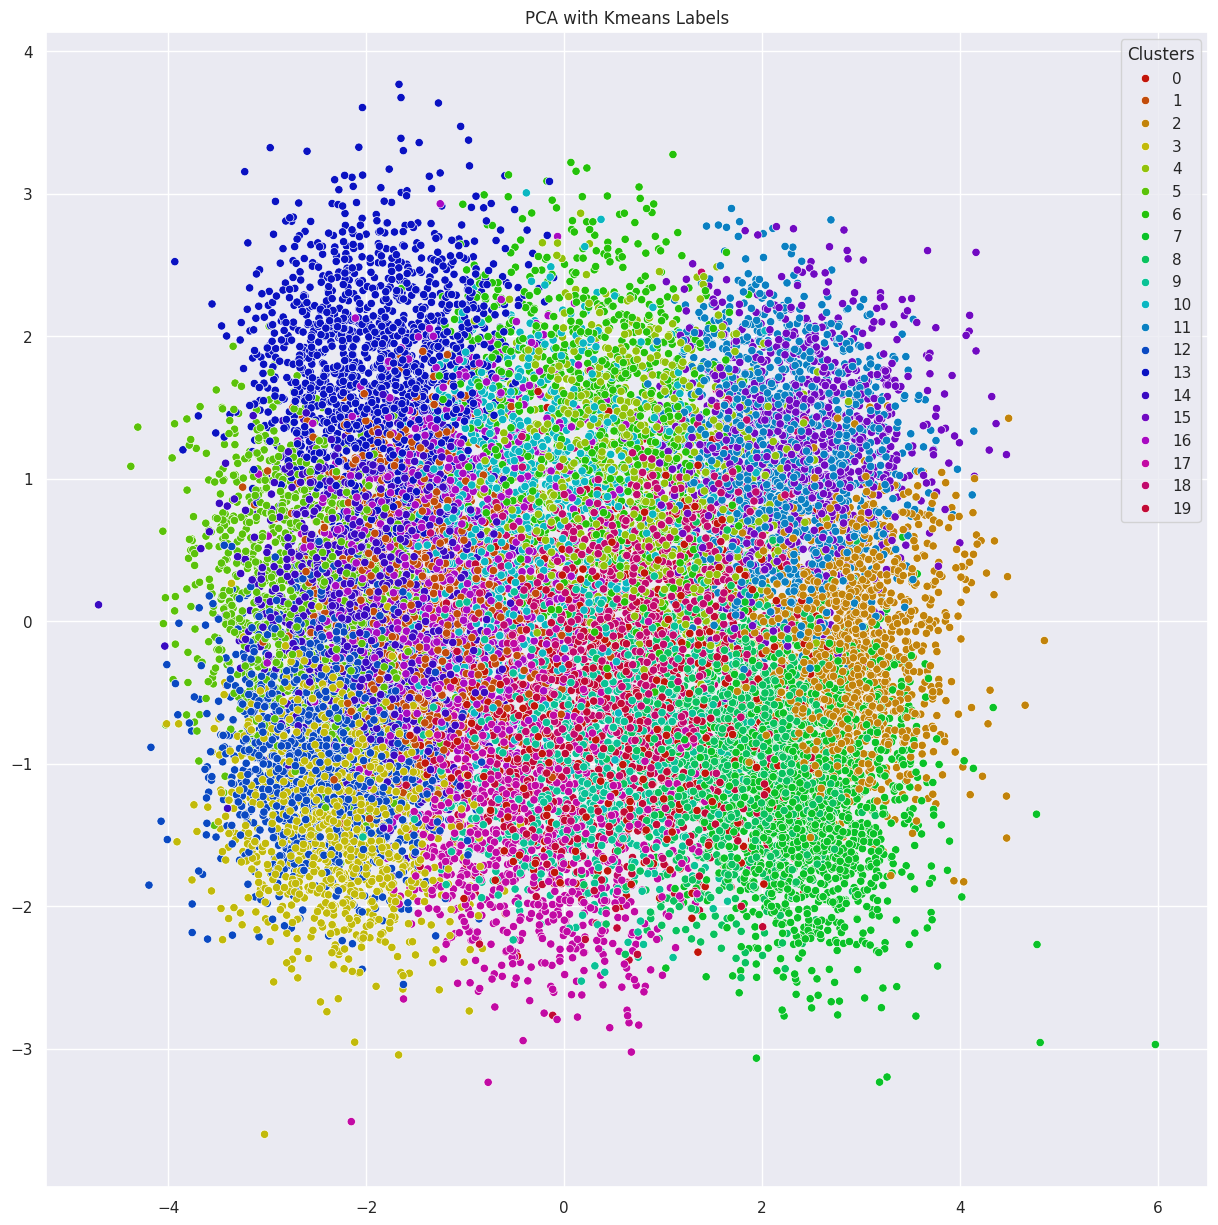

In [9]:
# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=doc_vectors_reduced_pca[:,0], y=doc_vectors_reduced_pca[:,1], hue=clusters_kmean.labels_, palette=palette)
plt.title('PCA with Kmeans Labels')
plt.legend(title='Clusters', loc='upper right')
plt.savefig("/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/results/word2vec_PCA_labeled_covid19.png")
plt.show()

### Dimensionality Reduction with t-SNE

Using [t-SNE](https://lvdmaaten.github.io/tsne) we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted. 

> t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space
> #### Cite: [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow: Second Edition | Aurélien Geron](https://github.com/ageron/handson-ml2)


In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(doc_vectors)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 22787 samples in 0.001s...
[t-SNE] Computed neighbors for 22787 samples in 2.506s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22787
[t-SNE] Computed conditional probabilities for sample 2000 / 22787
[t-SNE] Computed conditional probabilities for sample 3000 / 22787
[t-SNE] Computed conditional probabilities for sample 4000 / 22787
[t-SNE] Computed conditional probabilities for sample 5000 / 22787
[t-SNE] Computed conditional probabilities for sample 6000 / 22787
[t-SNE] Computed conditional probabilities for sample 7000 / 22787
[t-SNE] Computed conditional probabilities for sample 8000 / 22787
[t-SNE] Computed conditional probabilities for sample 9000 / 22787
[t-SNE] Computed conditional probabilities for sample 10000 / 22787
[t-SNE] Computed conditional probabilities for sample 11000 / 22787
[t-SNE] Computed conditional probabilities for sample 12000 / 22787
[t-SNE] Computed conditional probabilities for sa

/tmp/ipykernel_18398/1245678569.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)  # Specify x and y explicitly


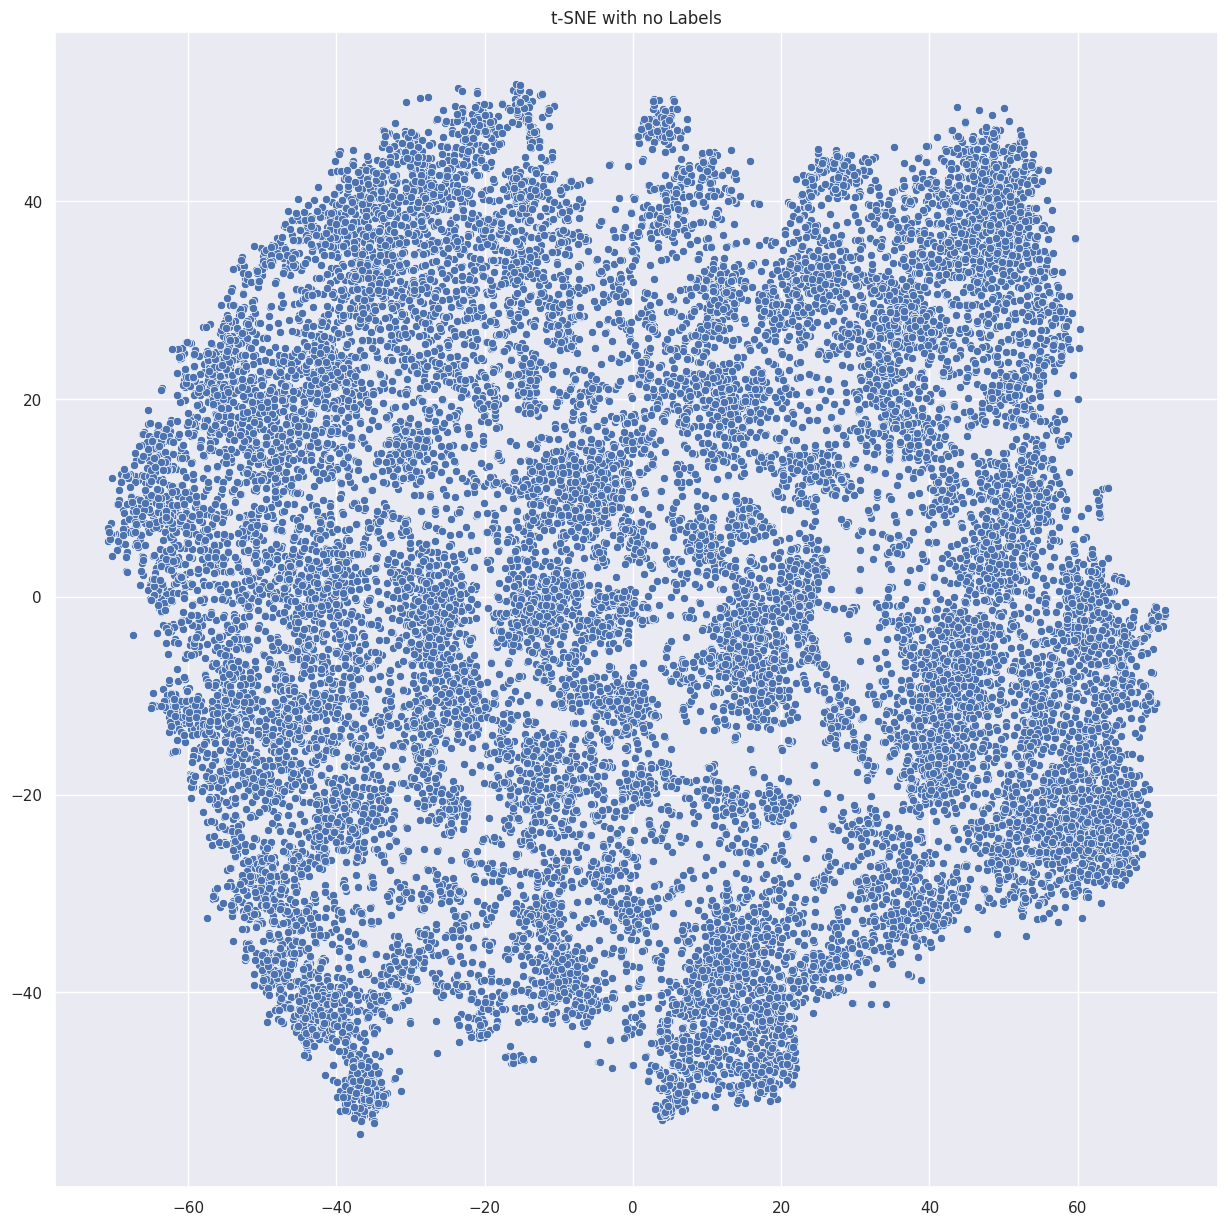

In [11]:

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)  # Specify x and y explicitly
plt.title('t-SNE with no Labels')
plt.savefig("/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/results/word2vec_TSNE_covid19.png")
plt.show()

In [12]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
clusters_kmean= kmeans.fit(X_embedded)
print(clusters_kmean.labels_)
y_pred = clusters_kmean.labels_

[12 12 12 ... 12 12  9]


In [13]:
from sklearn.metrics import silhouette_score

# Assuming X contains your data and labels contains the cluster labels
silhouette_avg = silhouette_score(X_embedded, y_pred )
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.36316893


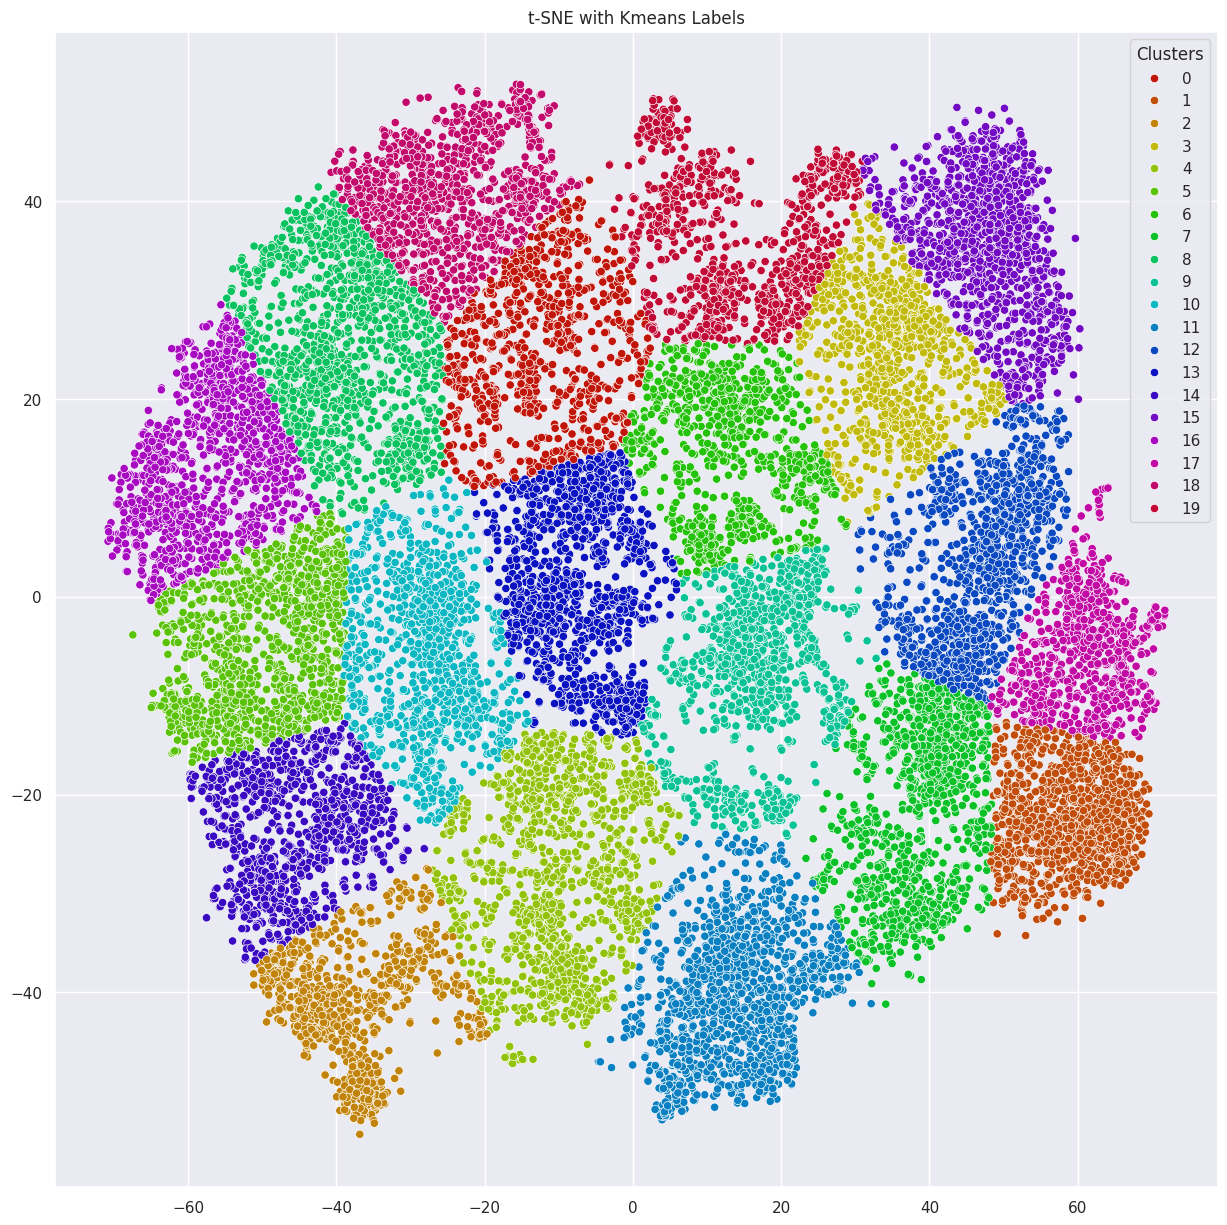

In [14]:
# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.legend(title='Clusters', loc='upper right')
plt.savefig("/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/results/word2vec_TSNE_labeled_covid19.png")
plt.show()

## Hierarchical Clustering

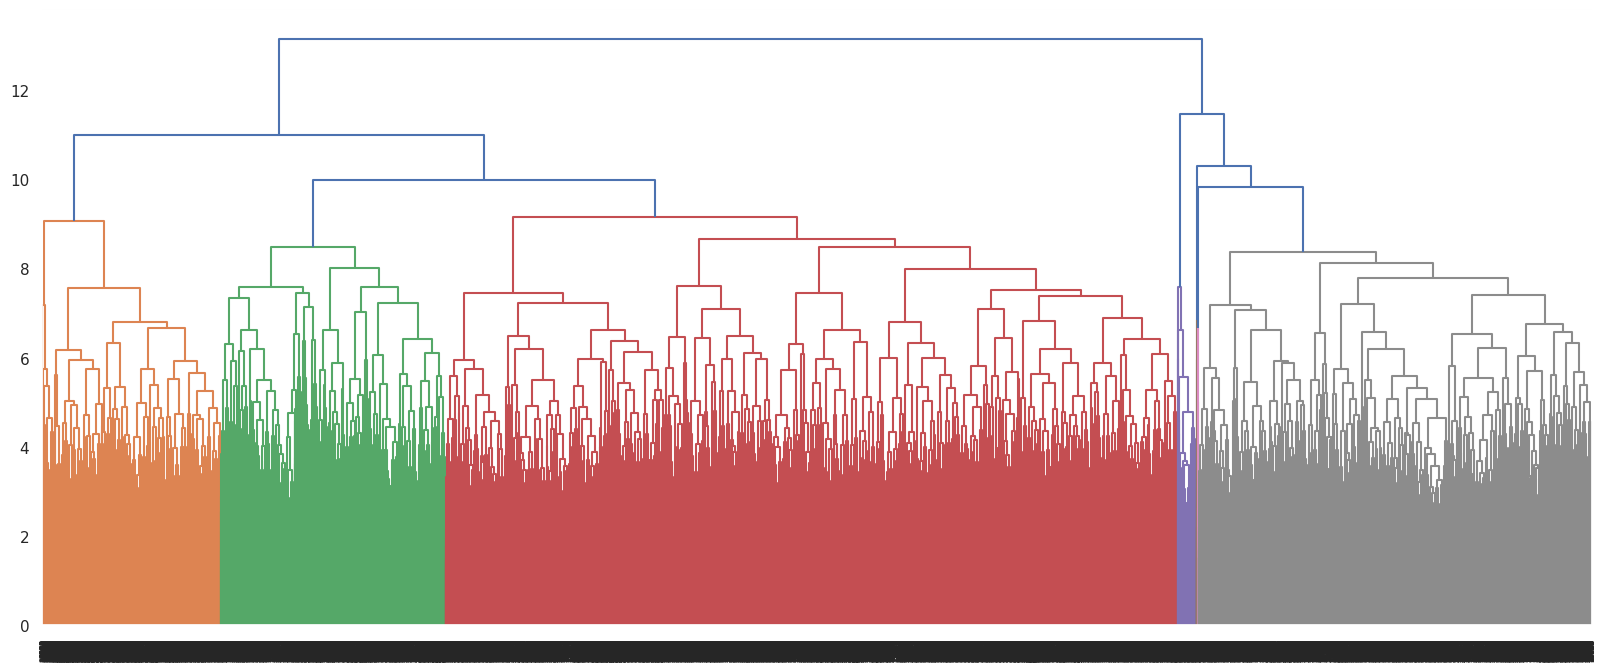

In [15]:
import scipy.cluster.hierarchy as sch 

plt.figure(figsize=(20,8))
dendrogram = sch.dendrogram(sch.linkage(doc_vectors_reduced_pca, method= 'complete'))


In [16]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score as sil 

metrics = ['euclidean']
linkages = ['complete' , 'single' , 'ward' , 'average']

for m in metrics:
    for l in linkages:
        hc=AgglomerativeClustering(n_clusters=2, metric=m, linkage=l)
        y_hc=hc.fit_predict(doc_vectors_reduced_pca)
        sil_score = sil(doc_vectors_reduced_pca, y_hc)
        print('For metric =',m,'and linkage =', l, 'Silhouette score is', np.round(sil_score,4))


For metric = euclidean and linkage = complete Silhouette score is 0.1709
For metric = euclidean and linkage = single Silhouette score is 0.3992
For metric = euclidean and linkage = ward Silhouette score is 0.1799
For metric = euclidean and linkage = average Silhouette score is 0.4356


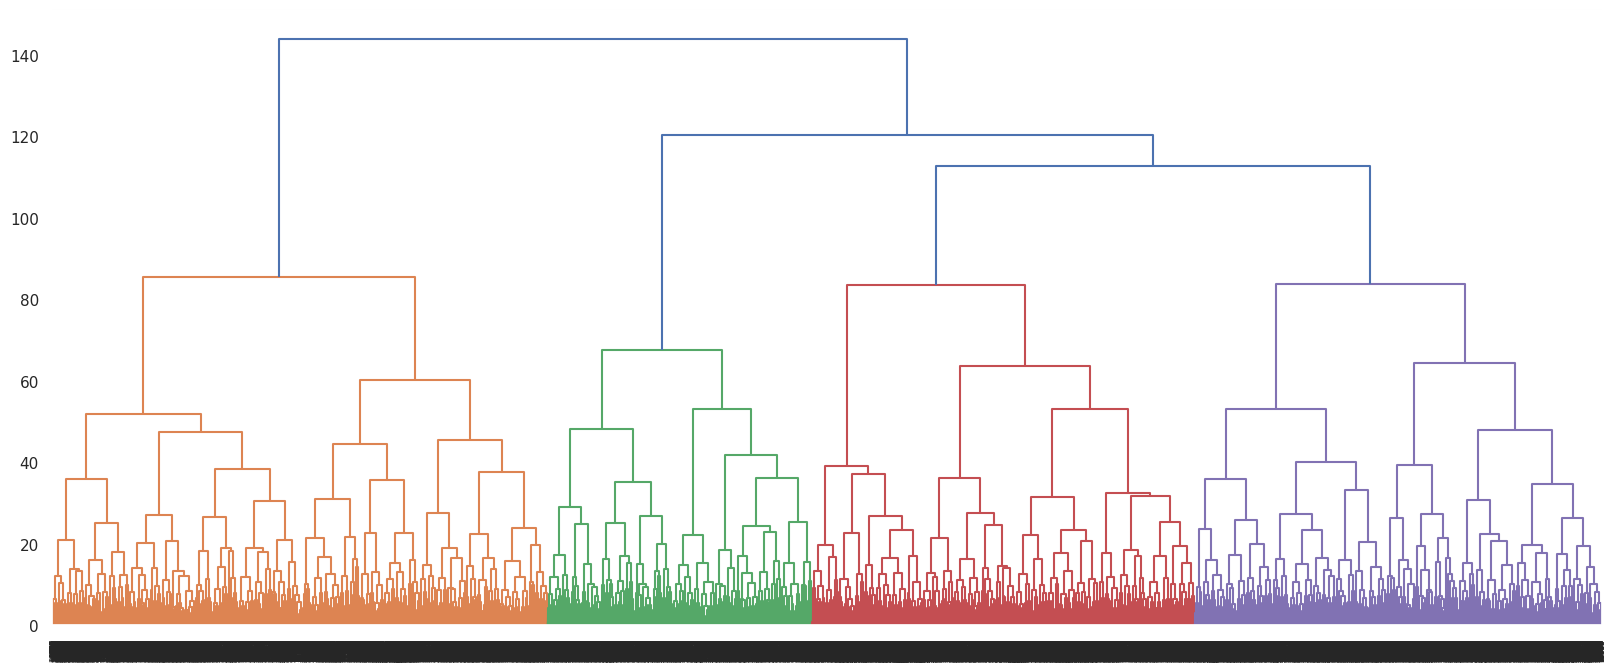

In [17]:
import scipy.cluster.hierarchy as sch 

plt.figure(figsize=(20,8))
dendrogram = sch.dendrogram(sch.linkage(X_embedded, method= 'complete'))


In [18]:
metrics = ['euclidean']
linkages = ['complete' , 'single' , 'ward' , 'average']

for m in metrics:
    for l in linkages:
        hc=AgglomerativeClustering(n_clusters=2, metric=m, linkage=l)
        y_hc=hc.fit_predict(X_embedded)
        sil_score = sil(X_embedded, y_hc)
        print('For metric =',m,'and linkage =', l, 'Silhouette score is', np.round(sil_score,4))


For metric = euclidean and linkage = complete Silhouette score is 0.3933
For metric = euclidean and linkage = single Silhouette score is 0.1547
For metric = euclidean and linkage = ward Silhouette score is 0.3864
For metric = euclidean and linkage = average Silhouette score is 0.3952


## Agglomerative Clustering

In [19]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

ac = AgglomerativeClustering(n_clusters=20)
clusters_agglo = ac.fit(doc_vectors_reduced_pca)
print(clusters_agglo.labels_)

[ 7  7 17 ...  7  7 11]


In [20]:
from sklearn.metrics import silhouette_score

# Assuming X contains your data and labels contains the cluster labels
silhouette_avg = silhouette_score(doc_vectors_reduced_pca, clusters_agglo.labels_ )
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.053982783


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


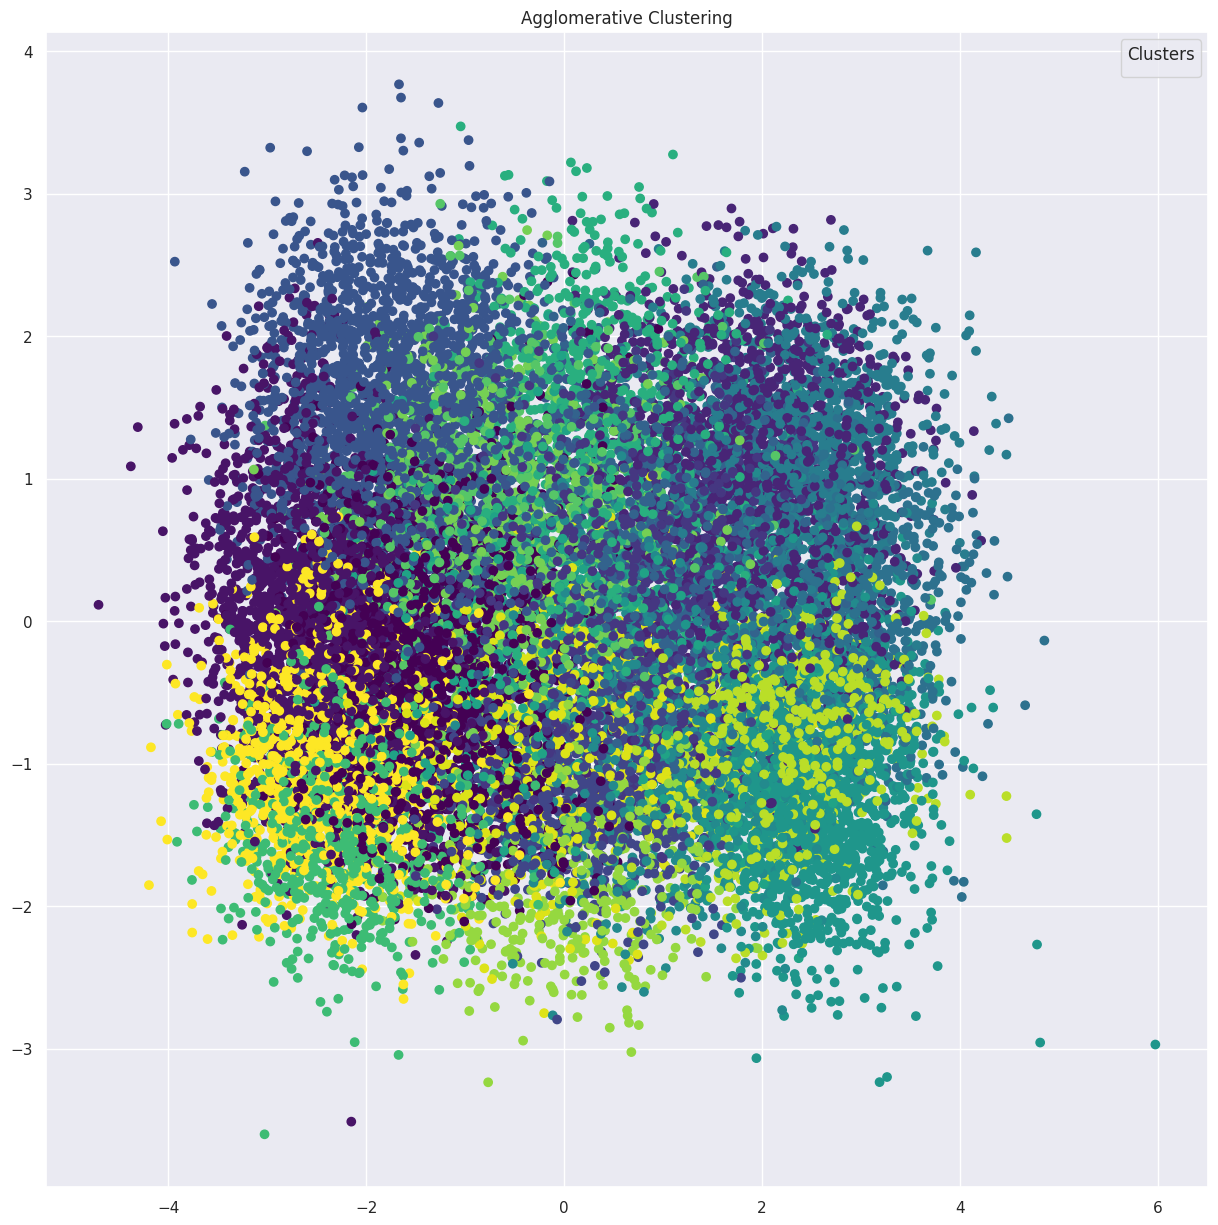

In [21]:
# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
plt.scatter(doc_vectors_reduced_pca[:, 0], doc_vectors_reduced_pca[:, 1], c=clusters_agglo.labels_, cmap='viridis')
plt.title("Agglomerative Clustering")
plt.legend(title='Clusters', loc='upper right')
plt.savefig("/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/results/word2vec_pca_agglomerative_labeled_covid19.png")
plt.show()

In [22]:

ac = AgglomerativeClustering(n_clusters=20)
clusters_agglo = ac.fit(X_embedded)
print(clusters_agglo.labels_)

[17  5 17 ...  5 17  8]


In [23]:
from sklearn.metrics import silhouette_score

# Assuming X contains your data and labels contains the cluster labels
silhouette_avg = silhouette_score(X_embedded, clusters_agglo.labels_ )
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.33006898


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


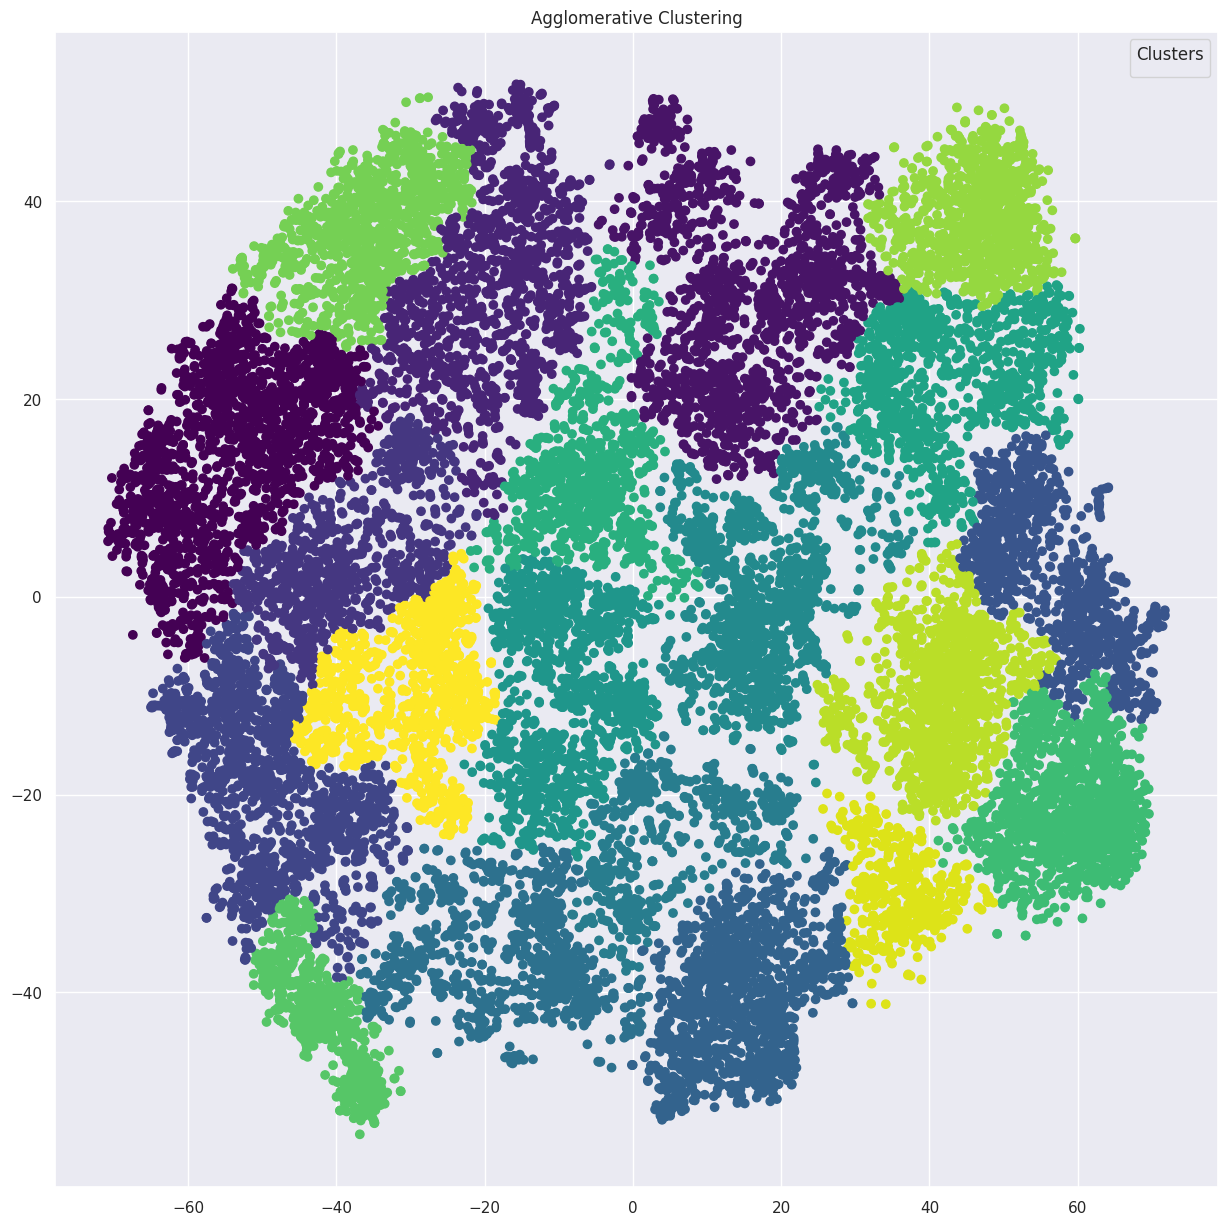

In [24]:
# sns settings
sns.set(rc={'figure.figsize':(15, 15)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=clusters_agglo.labels_, cmap='viridis')
plt.title("Agglomerative Clustering")
plt.legend(title='Clusters', loc='upper right')
plt.savefig("/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/results/word2vec_TSNE_agglomerative_labeled_covid19.png")
plt.show()

# Topic Modeling on Each Cluster

Now we will attempt to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use `LDA (Latent Dirichlet Allocation)`. 

In [25]:
# First we will create 20 vectorizers, one for each of our cluster labels
vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))



In [27]:
vectorized_data = []
cleaned_df['combined_text'] = cleaned_df['title'] + ' ' + cleaned_df['abstract']
df = cleaned_df.dropna(subset=['combined_text'])

for current_cluster, cvec in enumerate(vectorizers):
    cluster_data = cleaned_df.loc[clusters_kmean.labels_ == current_cluster, 'combined_text']
    if len(cluster_data) > 0:
        try:
            vectorized_data.append(cvec.fit_transform(cluster_data))
        except Exception as e:
            print("Error vectorizing cluster {}: {}".format(current_cluster, e))
            vectorized_data.append(None)
    else:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [28]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)

In [29]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [30]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [31]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [32]:
f=open('/home/asma-rashidian/Documents/DrRahmani_projects/project3-DM-24-Dey-1402/proceed_data/vectorizing_results/topics_word2vec.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [33]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [34]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, y_pred, test_size=0.2)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 18229
X_test size: 4558 



In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=-1)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  73.624 %
     Precision:  73.779 %
        Recall:  73.117 %
      F1 score:  73.186 %
